In [1]:
from pylab import *
import scipy.integrate
import time
import math

# Computation of diffusive $\gamma$-ray emission and comparison between cosmic rays flux models

## 1. Cross-section

In [8]:
# Quantities
m_p = 0.938272 # Proton mass in GeV
m_pi = 0.134976 # Pion mass in GeV
T_pth = (2.0 * m_pi) + m_pi**2 / (2.0 * m_p) # Threshold in GeV

# Maximum pi_0 energy
def EpimaxLAB(T_p):
    s = 2.0 * m_p * (T_p + 2.0 * m_p)
    gammaCM = (T_p + 2.0 * m_p) * s**(-1 / 2)
    EpiCM = (s - 4.0 * m_p**2 + m_pi**2) / (2.0 * s**(1 / 2))
    PpiCM = (EpiCM**2 - m_pi**2)**(1 / 2)
    BetaCM = (1.0 - gammaCM**(-2))**(1 / 2)
    EpimaxLABval = gammaCM * (EpiCM + PpiCM * BetaCM)
    return EpimaxLABval # in GeV

# Maximum gamma-ray energy
def Egammamax(T_p):
    gammapiLAB = EpimaxLAB(T_p) / m_pi
    BetapiLAB = (1.0 - gammapiLAB**(-2))**(1 / 2)
    Egmin = (m_pi / 2.0) * gammapiLAB * (1.0 - BetapiLAB)
    Egmax = (m_pi / 2.0) * gammapiLAB * (1.0 + BetapiLAB)
    return Egmax # in GeV

# pp total inelastic cross section (fitting the PDG data including TOTEM @ LHC)
def sigmainel(T_p):
    LX = np.log(T_p / T_pth)
    Thresh = max(0.0, (1.0 - (T_pth / T_p)**1.9))
    XS = (30.7 - 0.96 * LX + 0.18 * LX**2) * Thresh**3
    return XS # in mb

# First pi_0 production cross section. Valid for T_p <= 2 GeV. The channel included is pp->pp(pi_0)
def sigma1pi(T_p):
    MRES = 1.1883 # Resonance effective mass in GeV
    GammaRES = 0.2264 # Resonance effective width in GeV
    sigma0 = 7.66 * 10**(-3) # mb
    if T_p <= T_pth:
        XS1pi = 0.0
    if T_p > 2.0:
        XS1pi = 0.0
    else:
        s = 2.0 * m_p * (T_p + 2.0 * m_p)
        X = s**(1/2) - m_p
        eta = ( ((s - m_pi**2 - 4.0 * m_p**2)**2 - (16.0 * m_pi**2 * m_p**2))**(1/2) ) / (2 * m_pi * s**(1/2))
        gRES = (MRES**2 * (MRES**2 + GammaRES**2))**(1/2)
        KRES = (8.0**(1/2)) * MRES * GammaRES * gRES / (np.pi * (MRES**2 + gRES)**(1/2))
        fBW = m_p * (KRES / ((X**2 - MRES**2)**2 + (MRES * GammaRES)**2))
        XS1pi = sigma0 * (eta**1.95) * (1.0 + eta + eta**5) * (fBW**1.86)
    return XS1pi # in mb

# Second pion production cross section. Valid T_p <= 2 GeV. The channels included are p+p -> p+n +(pi+)+(pi_0), 
# p+p ->  D  +(pi+)+(pi:0), p+p -> p+p +2(pi_0)
def sigma2pi(T_p):
    if T_p < 0.56:
        XS2pi = 0.0
    if T_p > 2.0:
        XS2pi = 0.0
    else:
        XS2pi = 5.7 / (1.0 + np.exp(-9.3 * (T_p - 1.4)))
    return XS2pi # in mb

### Geant4

In [9]:
# Average pi_0 production multiplicity given by Geant4. Valid for T_p >= to 1 GeV
def multippi0Geant4(T_p):
    if T_p <= 2.0:
        multippi0 = 0
    if T_p >= 5.0:
        a1 = 0.728; a2 = 0.596; a3 = 0.491; a4 = 0.2503; a5 = 0.117
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    else: 
        Qp = (T_p - T_pth) / m_p
        multippi0 = -6.0 * 10**-3 + 0.237 * Qp - 0.023 * Qp**2
    return multippi0

# pi_0 production cross section by using experimental data for T_p<=2 GeV, and Geant4 multiplicity for T_p>2 GeV
def sigmapiGeant4(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0Geant4(T_p)
    return XSpi0 # in mb

# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, and for T_p >= 1 GeV is based on Geant4.
def AmaxGeant4(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p <= T_pth:
        Amax = 0
    if T_p > T_pth and T_p < 1.0:
        Amax = 5.9 * sigmapiGeant4(T_p) / EpimaxLAB(T_p)
    if T_p >= 1.0 and T_p < 5.0:
        b1 = 9.53; b2 = -0.52; b3 = 0.054;
        Amax = b1 * (theta_p**b2) * np.exp(b3 * Ltheta_p**2.0) * sigmapiGeant4(T_p) / m_p
    else: 
        b1 = 9.13; b2 = -0.35; b3 = 9.7 * 10**(-3);
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiGeant4(T_p) / m_p
    return Amax # in mb/GeV

# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV and Geant4 for T_p >= 1 GeV. 
def FGeant4(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    theta = T_p/m_p
    kappa = 3.29 - 0.2 * theta**(-1.5)
    q = (T_p - 1.0) / m_p
    C0 = 3.0 * m_pi / Y0
    FF = 0.0
    if X >= 0.0 and X < 1.0:
        FF = 0.0
        if T_p > T_pth and T_p < 1.0:
            FF = (1 - X)**kappa
        if T_p >= 1.0 and T_p <= 4.0:
            mu = 1.25 * q**1.25 * np.exp(-1.25 * q)
            beta = mu + 2.45
            gamma = mu + 1.45
            FF = (1 - X)**beta / (1 + X / C0)**gamma
        if T_p > 4.0 and T_p <= 20.0:
            mu = 1.25 * q**1.25 * np.exp(-1.25 * q)
            beta = 1.5 * mu + 4.95
            gamma = mu + 1.5
            FF = (1 - X)**beta / (1 + X / C0)**gamma
        if T_p > 20.0 and T_p <= 100.0:
            FF = (1 - X**0.5)**4.2 / (1 + X / C0)
        if T_p > 100.0: 
            FF = (1 - X**0.5)**4.9 / (1 + X / C0)
    return FF

# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for T_p >= 1 GeV.
def dsigmadEgammaGeant4(T_p, Egamma):
    dsigma = AmaxGeant4(T_p) * FGeant4(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossGeant4 = np.vectorize(dsigmadEgammaGeant4)

### Pythia8

In [10]:
# Average pi_0 production multiplicity given by Geant4 for T_p <= 50 GeV and Pythia 8 for T_p > 50 GeV
def multippi0Pythia8(T_p):
    if T_p <= 50.0:
        multippi0 = multippi0Geant4(T_p)
    else: 
        a1 = 0.652; a2 = 0.0016; a3 = 0.488; a4 = 0.1928; a5 = 0.483
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 50 GeV and Pythia8 multiplicity for T_p < 50 GeV
def sigmapiPythia8(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0Pythia8(T_p)
    return XSpi0 # in mb

# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 50 GeV is based on Geant4 and 
# for T_p > 50 GeV is based on Pythia8.
def AmaxPythia8(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p <= T_pth:
        Amax = 0
    if T_p > T_pth and T_p <= 50.0:
        Amax = AmaxGeant4(T_p)
    if T_p > 50.0:
        b1 = 9.06; b2 = -0.3795; b3 = 0.01105;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiPythia8(T_p) / m_p
    return Amax # in mb/GeV

# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 50 GeV and Pythia8 for T_p > 50 GeV
def FPythia8(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.5 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 50:
        FF = (1 - X**0.5)**4.0 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for 1 <= T_p <= 50 GeV and Pythia8 for T_p > 50 GeV
def dsigmadEgammaPythia8(T_p, Egamma):
    dsigma = AmaxPythia8(T_p) * FPythia8(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossPythia8 = np.vectorize(dsigmadEgammaPythia8)

### SIBYLL

In [11]:
# Average pi0 production multiplicity given by Geant4 for T_p <= 100 GeV and SIBYLL for T_p>100 GeV
def multippi0SYBILL(T_p): 
    if T_p <= 100.0:
        multippi0 = multippi0Geant4(T_p)
    else:
        a1 = 5.436; a2 = 0.254; a3 = 0.072; a4 = 0.075; a5 = 0.166
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 100 GeV and SIBYLL multiplicity for T_p > 100 GeV
def sigmapiSIBYLL(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0SYBILL(T_p)
    return XSpi0 # in mb

# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 100 GeV is based on Geant4
# and for T_p > 100 GeV is based on SIBYLL.
def AmaxSIBYLL(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    if T_p > T_pth and T_p <= 100.0:
        Amax = AmaxGeant4(T_p)
    if T_p > 100.0:
        b1 = 10.77; b2 = -0.412; b3 = 0.01264;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiSIBYLL(T_p) / m_p
    return Amax # in mb/GeV

# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 100 GeV and SIBYLL for T_p > 100 GeV
def FSIBYLL(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.55 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 100:
        FF = (1 - X**0.5)**3.6 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for for 1 <= T_p <= 100 GeV and SIBYLL for T_p > 100 GeV
def dsigmadEgammaSIBYLL(T_p, Egamma):
    dsigma = AmaxSIBYLL(T_p) * FSIBYLL(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossSIBYLL = np.vectorize(dsigmadEgammaSIBYLL)

### QGSJET

In [12]:
# Average pi0 production multiplicity given by Geant4 for T_p <= 100 GeV and QGSJET for T_p>100 GeV  
def multippi0QGSJET(T_p):
    if T_p <= 100.0:
        multippi0 = multippi0Geant4(T_p)
    else: 
        a1 = 0.908; a2 = 0.0009; a3 = 6.089; a4 = 0.176; a5 = 0.448
        xip = (T_p - 3.0) / m_p
        multippi0 = a1 * (xip**a4) * (1.0 + np.exp(-a2 * xip**a5)) * (1.0 - np.exp(-a3 * xip**0.25))
    return multippi0

# pi_0 production cross section by using experimental data for T_p <= 2 GeV, 
# Geant4 multiplicity for 2 < T_p <= 100 GeV and QGSJET multiplicity for T_p > 100 GeV
def sigmapiQGSJET(T_p):
    XSpi0 = sigma1pi(T_p) + sigma2pi(T_p) + sigmainel(T_p) * multippi0QGSJET(T_p)
    return XSpi0 # in mb

# Peak value of the gamma-ray differential cross section. 
# For T_p < 1 GeV is the fit from the experimental data, for 1 <= T_p <= 100 GeV is based on Geant4
# and for T_p > 100 GeV is based on QGSJET.
def AmaxQGSJET(T_p):
    theta_p = T_p / m_p
    Ltheta_p = np.log(theta_p)
    #if T_p > T_pth and T_p <= 100.0:
    if T_pth < T_p <= 100:
        Amax = AmaxGeant4(T_p)
    if T_p > 100.0:
        b1 = 13.16; b2 = -0.4419; b3 = 0.01439;
        Amax = b1 * theta_p**b2 * np.exp(b3 * Ltheta_p**2.0) * sigmapiQGSJET(T_p) / m_p
    return Amax # in mb/GeV

# Shape of the gamma-ray differential cross section function for a specific T_p.
# Includes the experimental data for T_p < 1 GeV Geant4 for 1 <= T_p <= 100 GeV and QGSJET for T_p > 100 GeV
def FQGSJET(T_p, Egamma):
    Y = Egamma + m_pi**2 / (4.0 * Egamma)
    Y0 = Egammamax(T_p) + m_pi**2 / (4.0 * Egammamax(T_p))
    X = (Y - m_pi) / (Y0 - m_pi)
    C0 = 3.55 * m_pi / Y0
    if X >= 0.0 and X < 1.0 and T_p > 100:
        FF = (1 - X**0.5)**4.5 / (1 + X / C0)
    else:
        FF = FGeant4(T_p, Egamma)
    return FF

# pp->pi0->gamma-ray differential cross section function
# Includes the experimental data for T_p < 1 GeV and Geant4 for for 1 <= T_p <= 100 GeV and QGSJET for T_p > 100 GeV
def dsigmadEgammaQGSJET(T_p, Egamma):
    dsigma = AmaxQGSJET(T_p) * FQGSJET(T_p, Egamma)
    return dsigma # in mb/GeV
diffcrossQGSJET = np.vectorize(dsigmadEgammaQGSJET)

## 3. Cosmic ray flux

### Dembinski

In [13]:
data = np.genfromtxt('Cosmic_Rays/CRdatadriven.txt')
E_Dembinski = data[:,0]
# Data is in (GeV cm^2 s sr)^-1, have to be renormalized
phi_p_Dembinski = data[:,1] * 1e4
phi_He_Dembinski = data[:,2] * 1e4
phi_Dembinski = np.zeros((len(data[:,0]), len((data[0,:]))))
phi_total_Dembinski = np.zeros(len(data[:,0]))
for i in range(1,29):
    phi_Dembinski[:,i] = data[:,i] * 1e4
    phi_total_Dembinski += phi_Dembinski[:,i]

### Prevotat

In [14]:
# Values chosen for DAMPE analysis
def Intensity(Z, N, E0, E1, gamma, E, n):
    E0 = Z * E0 / n
    E1 = Z * E1 / n
    I = (N / E0**2.5) * (E / E0)**(-gamma) * np.exp( - (E0 / E) - (E / E1)) * n**(-0.5)
    return I

# Protons
def I_p(E):
    N1 = 2.03e4; N2 = 3.67e3; N3 = 1.13e3; N4 = 2.55e3
    E01 = 6.21e0; E02 = 2.20e1; E03 = 4.41e3; E04 = 7.90e5
    E11 = 4.06e2; E12 = 2.81e4; E13 = 3.08e5; E14 = 1.90e7
    gamma1 = 3.25; gamma2 = 2.59; gamma3 = 2.42; gamma4 = 3.02
    I1 = Intensity(1, N1, E01, E11, gamma1, E, 1)
    I2 = Intensity(1, N2, E02, E12, gamma2, E, 1)
    I3 = Intensity(1, N3, E03, E13, gamma3, E, 1)
    I4 = Intensity(1, N4, E04, E14, gamma4, E, 1)
    I_total = I1 + I2 + I3 + I4
    return I_total

# Helium
def I_He(E):
    N1 = 1.06e4; N2 = 2.73e3; N3 = 1.38e3; N4 = 1.73e3
    E01 = 6.21e0; E02 = 2.20e1; E03 = 4.41e3; E04 = 7.90e5
    E11 = 4.06e2; E12 = 2.81e4; E13 = 3.08e5; E14 = 1.90e7
    gamma1 = 3.25; gamma2 = 2.59; gamma3 = 2.42; gamma4 = 3.02
    I1 = Intensity(2, N1, E01, E11, gamma1, E, 4)
    I2 = Intensity(2, N2, E02, E12, gamma2, E, 4)
    I3 = Intensity(2, N3, E03, E13, gamma3, E, 4)
    I4 = Intensity(2, N4, E04, E14, gamma4, E, 4)
    I_total = I1 + I2 + I3 + I4
    return I_total

# CNO
def I_CNO(E):
    N1 = 7.20e3; N2 = 2.10e3; N3 = 1.23e3; N4 = 7.01e2
    E01 = 6.21e0; E02 = 2.20e1; E03 = 4.41e3; E04 = 7.90e5
    E11 = 4.06e2; E12 = 2.81e4; E13 = 3.08e5; E14 = 1.90e7
    gamma1 = 3.25; gamma2 = 2.59; gamma3 = 2.42; gamma4 = 3.02
    I1 = Intensity(7, N1, E01, E11, gamma1, E, 14)
    I2 = Intensity(7, N2, E02, E12, gamma2, E, 14)
    I3 = Intensity(7, N3, E03, E13, gamma3, E, 14)
    I4 = Intensity(7, N4, E04, E14, gamma4, E, 14)
    I_total = I1 + I2 + I3 + I4
    return I_total

# Iron
def I_Fe(E):
    N1 = 2.50e3; N2 = 1.03e3; N3 = 1.00e2; N4 = 3.50e2
    E01 = 6.21e0; E02 = 2.20e1; E03 = 4.41e3; E04 = 7.90e5
    E11 = 4.06e2; E12 = 2.81e4; E13 = 3.08e5; E14 = 1.90e7
    gamma1 = 3.25; gamma2 = 2.59; gamma3 = 2.42; gamma4 = 3.02
    I1 = Intensity(26, N1, E01, E11, gamma1, E, 56)
    I2 = Intensity(26, N2, E02, E12, gamma2, E, 56)
    I3 = Intensity(26, N3, E03, E13, gamma3, E, 56)
    I4 = Intensity(26, N4, E04, E14, gamma4, E, 56)
    I_total = I1 + I2 + I3 + I4
    return I_total

def I_total(E):
    intensity_p = I_p(E)
    intensity_He = I_He(E)
    intensity_CNO = I_CNO(E)
    intensity_Fe = I_Fe(E)
    return intensity_p + intensity_He + intensity_CNO + intensity_Fe

### Lipari + my extension

In [49]:
# Model for proton
def Phi_proton_nucleon(E):
    n = 1
    K = 0.0454255 * n**2
    E0 = 0.1 / n
    alpha1 = 2.805; alpha2 = 2.56; alpha3 = 2.814; alpha4 = 1.335; alpha5 = 4.025
    omega1 = 0.28; omega2 = 0.163; omega3 = 0.648; omega4 = 0.941
    Eb1 = 0.670 / n; Eb2 = 16 / n; Eb3 = 0.799 / n; Eb4 = 3.777  / n
    delta1 = alpha2 - alpha1
    delta2 = alpha3 - alpha2
    delta3 = alpha4 - alpha3
    delta4 = alpha5 - alpha4
    phi = K * ((E/1e3) / E0)**(-alpha3) * (1 + ((E/1e3) / Eb1)**(1 / omega1))**(-delta1 * omega1) * (1 + ((E/1e3) / Eb2)**(1 / omega2))**(-delta2 * omega2) * (1 + ((E/1e6) / Eb3)**(1 / omega3))**(-delta3 * omega3) * (1 + ((E/1e6) / Eb4)**(1 / omega4))**(-delta4 * omega4)
    return phi

# Model for He
def Phi_He_nucleon(E):
    n = 4
    K = 0.0332187 * n**2
    E0 = 0.1 / n
    alpha1 = 2.702; alpha2 = 2.464; alpha3 = 2.733; alpha4 = 2.3; alpha5 = 4.22
    omega1 = 0.272; omega2 = 0.056; omega3 = 0.1; omega4 = 0.701
    Eb1 = 1.207 / n; Eb2 = 32.014 / n; Eb3 = 0.526 / n; Eb4 = 6.168 / n
    delta1 = alpha2 - alpha1
    delta2 = alpha3 - alpha2
    delta3 = alpha4 - alpha3
    delta4 = alpha5 - alpha4
    phi = K * ((E/1e3) / E0)**(-alpha3) * (1 + ((E/1e3) / Eb1)**(1 / omega1))**(-delta1 * omega1) * (1 + ((E/1e3) / Eb2)**(1 / omega2))**(-delta2 * omega2) * (1 + ((E/1e6) / Eb3)**(1 / omega3))**(-delta3 * omega3) * (1 + ((E/1e6) / Eb4)**(1 / omega4))**(-delta4 * omega4)
    return phi

# Model for He
def Phi_He_shape(E):
    n = 4
    E0 = 0.1 / n
    alpha1 = 2.702; alpha2 = 2.464; alpha3 = 2.733; alpha4 = 2.3; alpha5 = 4.22
    omega1 = 0.272; omega2 = 0.056; omega3 = 0.1; omega4 = 0.701
    Eb1 = 1.207 / n; Eb2 = 32.014 / n; Eb3 = 0.526 / n; Eb4 = 6.168 / n
    delta1 = alpha2 - alpha1
    delta2 = alpha3 - alpha2
    delta3 = alpha4 - alpha3
    delta4 = alpha5 - alpha4
    phi = ((E/1e3) / E0)**(-alpha3) * (1 + ((E/1e3) / Eb1)**(1 / omega1))**(-delta1 * omega1) * (1 + ((E/1e3) / Eb2)**(1 / omega2))**(-delta2 * omega2) * (1 + ((E/1e6) / Eb3)**(1 / omega3))**(-delta3 * omega3) * (1 + ((E/1e6) / Eb4)**(1 / omega4))**(-delta4 * omega4)
    return phi

# Model for heavy nuclei
def Phi_heavy_nucleon(E, A):
    alpha = 2.733
    K_p = 0.0454255
    K_He = 0.0332187
    K_A = 1 * (K_p + (K_He * 2**alpha)) * (2**alpha * A**-alpha)
    return K_A * A**2 * Phi_He_shape(E)

# Model for all particles
def Phi_total_nucleon(E, A):
    phi = Phi_proton_nucleon(E) + Phi_He_nucleon(E) + Phi_heavy_nucleon(E, A)
    return phi

## Computation of diffusive gamma ray emission

### Integral over energy

In [355]:
# SECOND INTEGRAL
    
def Integral_energy(Egamma, hadronic_model, cr_model, A):
    
    # Egamma - Gamma-ray energy [GeV]
    # theta - Latitude angle [degrees]
    # phi - Longitude angle [degrees]
    # gas_model - Options: GALPROP
    # hadronic_model - Options: Geant4, Pythia8, SIBYLL, QGSJET
    # cr_model = Options: Dembinski, Lipari
    
    indexE = np.where(np.logical_and(E_Dembinski>=Egamma, E_Dembinski<=1e8))
    Ep = E_Dembinski[indexE]
    
    # Cross-section model
    if hadronic_model == 'Geant4':
        dsigmadE = diffcrossGeant4(Ep, Egamma) * 1e-27
    if hadronic_model == 'Pythia8':
        dsigmadE = diffcrossPythia8(Ep, Egamma) * 1e-27
    if hadronic_model == 'SIBYLL':
        dsigmadE = diffcrossSIBYLL(Ep, Egamma) * 1e-27
    if hadronic_model == 'QGSJET':
        dsigmadE = diffcrossQGSJET(Ep, Egamma) * 1e-27
        
    # Cosmic rays model
    if cr_model == 'Dembinski':
        flux_CR = phi_total_Dembinski[indexE] / 1e4
    if cr_model == 'Lipari':
        flux_CR = Phi_total_nucleon(Ep, A) / 1e4
    if cr_model == 'Prevotat':
        flux_CR = I_total(Ep) / 1e4
        
    integral_E = scipy.integrate.simpson(dsigmadE * flux_CR, Ep)
    return integral_E
vec_Integral_energy = np.vectorize(Integral_energy)

In [356]:
# Energy range
index_analysis = np.where(np.logical_and(E_Dembinski >= 1e1, E_Dembinski <= 1e8))
Energy_gamma = E_Dembinski[index_analysis]

# Runnung integral
start_time = time.time()
integral_energy_Dembinski = vec_Integral_energy(Energy_gamma, 'Pythia8', 'Dembinski', 1)
integral_energy_Lipari_Fe = vec_Integral_energy(Energy_gamma, 'Pythia8', 'Lipari', 56)
integral_energy_Lipari_C = vec_Integral_energy(Energy_gamma, 'Pythia8', 'Lipari', 12)
integral_energy_Prevotat = vec_Integral_energy(Energy_gamma, 'Pythia8', 'Prevotat', 1)
print("Run time: %s seconds" % (time.time() - start_time))

# Loading and interpolating integrals over line of sight
energy_los = np.genfromtxt('Integral_line_of_sight/energy_los_TIBET.txt')
integral_los_innerGalaxy = np.genfromtxt('Integral_line_of_sight/integral_los_innerGalaxy_TIBET.txt') * 3.08567758128e21
integral_los_outerGalaxy = np.genfromtxt('Integral_line_of_sight/integral_los_outerGalaxy_TIBET.txt') * 3.08567758128e21

# Computing product between two integral
def I_gamma(sky_region, cr_model):
    
    if sky_region == 'innerGalaxy':
        integral_los = scipy.interpolate.PchipInterpolator(energy_los, integral_los_innerGalaxy)
    if sky_region == 'outerGalaxy':
        integral_los = scipy.interpolate.PchipInterpolator(energy_los, integral_los_outerGalaxy)
        
    if cr_model == 'Dembinski':
        integral_energy = integral_energy_Dembinski
    if cr_model == 'Lipari_Fe':
        integral_energy = integral_energy_Lipari_Fe
    if cr_model == 'Lipari_C':
        integral_energy = integral_energy_Lipari_C
    if cr_model == 'Prevotat':
        integral_energy = integral_energy_Prevotat
        
    return integral_energy * integral_los(Energy_gamma)

np.savetxt('Gamma_Rays/Energy_gamma_TIBET.txt', Energy_gamma)

Igamma_Dembinski_Pythia8_innerGalaxy = I_gamma('innerGalaxy', 'Dembinski')
Igamma_Dembinski_Pythia8_outerGalaxy = I_gamma('outerGalaxy', 'Dembinski')
np.savetxt('Gamma_Rays/Igamma_Dembinski_Pythia8_innerGalaxy_TIBET.txt', Igamma_Dembinski_Pythia8_innerGalaxy)
np.savetxt('Gamma_Rays/Igamma_Dembinski_Pythia8_outerGalaxy_TIBET.txt', Igamma_Dembinski_Pythia8_outerGalaxy)

Igamma_Lipari_Fe_Pythia8_innerGalaxy = I_gamma('innerGalaxy', 'Lipari_Fe')
Igamma_Lipari_Fe_Pythia8_outerGalaxy = I_gamma('outerGalaxy', 'Lipari_Fe')
np.savetxt('Gamma_Rays/Igamma_Lipari_Fe_Pythia8_innerGalaxy_TIBET.txt', Igamma_Lipari_Fe_Pythia8_innerGalaxy)
np.savetxt('Gamma_Rays/Igamma_Lipari_Fe_Pythia8_outerGalaxy_TIBET.txt', Igamma_Lipari_Fe_Pythia8_outerGalaxy)

Igamma_Lipari_C_Pythia8_innerGalaxy = I_gamma('innerGalaxy', 'Lipari_C')
Igamma_Lipari_C_Pythia8_outerGalaxy = I_gamma('outerGalaxy', 'Lipari_C')
np.savetxt('Gamma_Rays/Igamma_Lipari_C_Pythia8_innerGalaxy_TIBET.txt', Igamma_Lipari_C_Pythia8_innerGalaxy)
np.savetxt('Gamma_Rays/Igamma_Lipari_C_Pythia8_outerGalaxy_TIBET.txt', Igamma_Lipari_C_Pythia8_outerGalaxy)

Igamma_Prevotat_Pythia8_innerGalaxy = I_gamma('innerGalaxy', 'Prevotat')
Igamma_Prevotat_Pythia8_outerGalaxy = I_gamma('outerGalaxy', 'Prevotat')
np.savetxt('Gamma_Rays/Igamma_Prevotat_Pythia8_innerGalaxy_TIBET.txt', Igamma_Prevotat_Pythia8_innerGalaxy)
np.savetxt('Gamma_Rays/Igamma_Prevotat_Pythia8_outerGalaxy_TIBET.txt', Igamma_Prevotat_Pythia8_outerGalaxy)

Run time: 3.321660280227661 seconds


## Plotting

In [357]:
Energy_gamma = np.genfromtxt('Gamma_Rays/Energy_gamma_TIBET.txt')
Igamma_Lipari_Fe_Pythia8_innerGalaxy = np.genfromtxt('Gamma_Rays/Igamma_Lipari_Fe_Pythia8_innerGalaxy_TIBET.txt')
Igamma_Lipari_Fe_Pythia8_outerGalaxy = np.genfromtxt('Gamma_Rays/Igamma_Lipari_Fe_Pythia8_outerGalaxy_TIBET.txt')
Igamma_Lipari_C_Pythia8_innerGalaxy = np.genfromtxt('Gamma_Rays/Igamma_Lipari_C_Pythia8_innerGalaxy_TIBET.txt')
Igamma_Lipari_C_Pythia8_outerGalaxy = np.genfromtxt('Gamma_Rays/Igamma_Lipari_C_Pythia8_outerGalaxy_TIBET.txt')
Igamma_Dembinski_Pythia8_innerGalaxy = np.genfromtxt('Gamma_Rays/Igamma_Dembinski_Pythia8_innerGalaxy_TIBET.txt')
Igamma_Dembinski_Pythia8_outerGalaxy = np.genfromtxt('Gamma_Rays/Igamma_Dembinski_Pythia8_outerGalaxy_TIBET.txt')
Igamma_Prevotat_Pythia8_innerGalaxy = np.genfromtxt('Gamma_Rays/Igamma_Prevotat_Pythia8_innerGalaxy_TIBET.txt')
Igamma_Prevotat_Pythia8_outerGalaxy = np.genfromtxt('Gamma_Rays/Igamma_Prevotat_Pythia8_outerGalaxy_TIBET.txt')

In [358]:
# TIBET region 25<l<100 and |b|<5. Energy in TeV and dN/dE*E^2.7 (GeV^1.7 cm^-2 s^-1 sr^-1) 
data_TIBET_innerGalaxy = np.genfromtxt('Data/TIBET_innerGalaxy.txt')
E_TIBET_innerGalaxy = data_TIBET_innerGalaxy[:,0] * 1e3
E_max_TIBET_innerGalaxy = data_TIBET_innerGalaxy[:,1] * 1e3
E_min_TIBET_innerGalaxy = data_TIBET_innerGalaxy[:,2] * 1e3
phi_TIBET_innerGalaxy = data_TIBET_innerGalaxy[:,3]
phi_max_TIBET_innerGalaxy = data_TIBET_innerGalaxy[:,4]
phi_min_TIBET_innerGalaxy = data_TIBET_innerGalaxy[:,5]

# TIBET region 50<l<200 and |b|<5. Energy in TeV and dN/dE*E^2.7 (GeV^1.7 cm^-2 s^-1 sr^-1) 
data_TIBET_outerGalaxy = np.genfromtxt('Data/TIBET_outerGalaxy.txt')
E_TIBET_outerGalaxy = data_TIBET_outerGalaxy[:,0] * 1e3
E_max_TIBET_outerGalaxy = data_TIBET_outerGalaxy[:,1] * 1e3
E_min_TIBET_outerGalaxy = data_TIBET_outerGalaxy[:,2] * 1e3
phi_TIBET_outerGalaxy = data_TIBET_outerGalaxy[:,3]
phi_max_TIBET_outerGalaxy = data_TIBET_outerGalaxy[:,4]
phi_min_TIBET_outerGalaxy = data_TIBET_outerGalaxy[:,5]

In [359]:
# Fermi region 25<l<100 and |b|<5. Energy in MeV and dN/dE*E (MeV^-1 cm^-2 s^-1 sr^-1) 
E_Fermi_innerGalaxy = np.genfromtxt('Data/Fermi/E_center_inner.txt') * 1e-3
E_max_Fermi_innerGalaxy = np.genfromtxt('Data/Fermi/xerr_up_inner.txt') * 1e-3
E_min_Fermi_innerGalaxy = np.genfromtxt('Data/Fermi/xerr_do_inner.txt') * 1e-3
phi_Fermi_innerGalaxy = np.genfromtxt('Data/Fermi/flux_inner.txt') / 1e-3
phi_max_Fermi_innerGalaxy = np.genfromtxt('Data/Fermi/yerr_inner.txt') / (E_Fermi_innerGalaxy*1e3)**2
phi_min_Fermi_innerGalaxy = np.genfromtxt('Data/Fermi/yerr_inner.txt') / (E_Fermi_innerGalaxy*1e3)**2
phi_max_Fermi_innerGalaxy = phi_max_Fermi_innerGalaxy / 1e-3
phi_min_Fermi_innerGalaxy = phi_min_Fermi_innerGalaxy / 1e-3

# Fermi region 50<l<200 and |b|<5. Energy in TeV and dN/dE*E (MeV^-1 cm^-2 s^-1 sr^-1) 
E_Fermi_outerGalaxy = np.genfromtxt('Data/Fermi/E_center_outer.txt') * 1e-3
E_max_Fermi_outerGalaxy = np.genfromtxt('Data/Fermi/xerr_up_outer.txt') * 1e-3
E_min_Fermi_outerGalaxy = np.genfromtxt('Data/Fermi/xerr_do_outer.txt') * 1e-3
phi_Fermi_outerGalaxy = np.genfromtxt('Data/Fermi/flux_outer.txt') / 1e-3
phi_max_Fermi_outerGalaxy = np.genfromtxt('Data/Fermi/yerr_outer.txt') / (E_Fermi_outerGalaxy*1e3)**2
phi_min_Fermi_outerGalaxy = np.genfromtxt('Data/Fermi/yerr_outer.txt') / (E_Fermi_outerGalaxy*1e3)**2
phi_max_Fermi_outerGalaxy = phi_max_Fermi_outerGalaxy / 1e-3
phi_min_Fermi_outerGalaxy = phi_min_Fermi_outerGalaxy / 1e-3

Text(0.5, 1.0, 'Diffusive gamma-ray spectrum for $|b|<5^\\circ$ and $25^\\circ < l < 100^\\circ$')

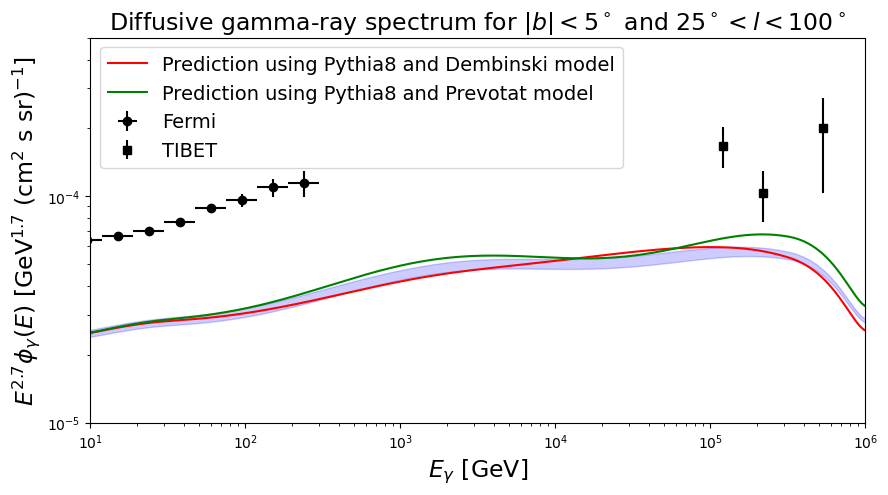

In [360]:
# Inner Galaxy plot
alpha = 2.7
plt.figure(figsize=(10, 5))
plt.fill_between(Energy_gamma, Igamma_Lipari_C_Pythia8_innerGalaxy * Energy_gamma**alpha, Igamma_Lipari_Fe_Pythia8_innerGalaxy * Energy_gamma**alpha, color='blue', alpha=0.2)
plt.plot(Energy_gamma, Igamma_Dembinski_Pythia8_innerGalaxy * Energy_gamma**alpha, label='Prediction using Pythia8 and Dembinski model', color='red')
plt.plot(Energy_gamma, Igamma_Prevotat_Pythia8_innerGalaxy * Energy_gamma**alpha, label='Prediction using Pythia8 and Prevotat model', color='green')
plt.errorbar(E_Fermi_innerGalaxy, phi_Fermi_innerGalaxy * E_Fermi_innerGalaxy**alpha, yerr=(phi_min_Fermi_innerGalaxy, phi_max_Fermi_innerGalaxy)*E_Fermi_innerGalaxy**alpha, xerr=(E_min_Fermi_innerGalaxy, E_max_Fermi_innerGalaxy), fmt='o', color='black', label='Fermi')
plt.errorbar(E_TIBET_innerGalaxy, phi_TIBET_innerGalaxy, yerr=(phi_min_TIBET_innerGalaxy, phi_max_TIBET_innerGalaxy), fmt='s', color='black', label='TIBET')
plt.plot(1e6, 0.0006462617957469503, 'o')
plt.loglog()
plt.ylim(1e-5, 5e-4)
plt.xlim(1e1, 1e6)
plt.xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
plt.ylabel(r'$E^{2.7}\phi_\gamma(E)$ [GeV$^{1.7}$ (cm$^2$ s sr)$^{-1}$]', fontsize=17)
plt.legend(ncol=1, fontsize=14, loc='upper left')
plt.title('Diffusive gamma-ray spectrum for $|b|<5^\circ$ and $25^\circ < l < 100^\circ$', fontsize=17)

Text(0.5, 1.0, 'Diffusive gamma-ray spectrum for $|b|<5^\\circ$ and $50^\\circ < l < 200^\\circ$')

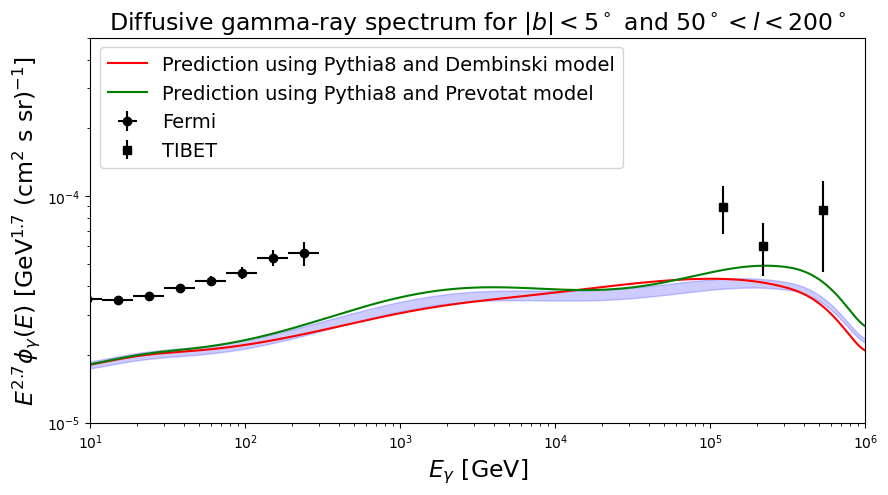

In [361]:
# Outer Galaxy plot
alpha = 2.7
plt.figure(figsize=(10, 5))
plt.fill_between(Energy_gamma, Igamma_Lipari_C_Pythia8_outerGalaxy * Energy_gamma**alpha, Igamma_Lipari_Fe_Pythia8_outerGalaxy * Energy_gamma**alpha, color='blue', alpha=0.2)
plt.plot(Energy_gamma, Igamma_Dembinski_Pythia8_outerGalaxy * Energy_gamma**alpha, label='Prediction using Pythia8 and Dembinski model', color='red')
plt.plot(Energy_gamma, Igamma_Prevotat_Pythia8_outerGalaxy * Energy_gamma**alpha, label='Prediction using Pythia8 and Prevotat model', color='green')
plt.errorbar(E_Fermi_outerGalaxy, phi_Fermi_outerGalaxy * E_Fermi_outerGalaxy**alpha, yerr=(phi_min_Fermi_outerGalaxy, phi_max_Fermi_outerGalaxy)*E_Fermi_outerGalaxy**alpha, xerr=(E_min_Fermi_outerGalaxy, E_max_Fermi_outerGalaxy), fmt='o', color='black', label='Fermi')
plt.errorbar(E_TIBET_outerGalaxy, phi_TIBET_outerGalaxy, yerr=(phi_min_TIBET_outerGalaxy, phi_max_TIBET_outerGalaxy), fmt='s', color='black', label='TIBET')
plt.loglog()
plt.ylim(1e-5, 5e-4)
plt.xlim(1e1, 1e6)
plt.xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
plt.ylabel(r'$E^{2.7}\phi_\gamma(E)$ [GeV$^{1.7}$ (cm$^2$ s sr)$^{-1}$]', fontsize=17)
plt.legend(ncol=1, fontsize=14, loc='upper left')
plt.title('Diffusive gamma-ray spectrum for $|b|<5^\circ$ and $50^\circ < l < 200^\circ$', fontsize=17)

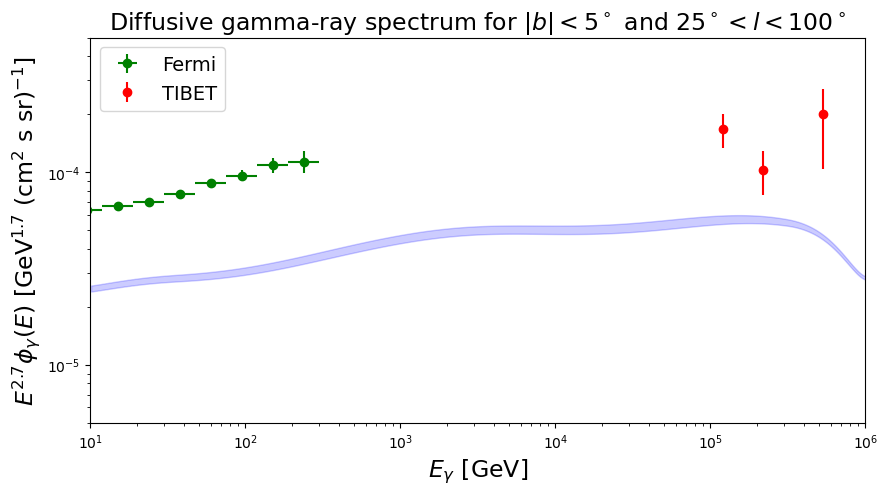

In [362]:
# Inner Galaxy plot
alpha = 2.7
plt.figure(figsize=(10, 5))
plt.fill_between(Energy_gamma, Igamma_Lipari_C_Pythia8_innerGalaxy * Energy_gamma**alpha, Igamma_Lipari_Fe_Pythia8_innerGalaxy * Energy_gamma**alpha, color='blue', alpha=0.2)
plt.errorbar(E_Fermi_innerGalaxy, phi_Fermi_innerGalaxy * E_Fermi_innerGalaxy**alpha, yerr=(phi_min_Fermi_innerGalaxy, phi_max_Fermi_innerGalaxy)*E_Fermi_innerGalaxy**alpha, xerr=(E_min_Fermi_innerGalaxy, E_max_Fermi_innerGalaxy), fmt='o', color='green', label='Fermi')
plt.errorbar(E_TIBET_innerGalaxy, phi_TIBET_innerGalaxy, yerr=(phi_min_TIBET_innerGalaxy, phi_max_TIBET_innerGalaxy), fmt='o', color='red', label='TIBET')
plt.loglog()
plt.ylim(5e-6, 5e-4)
plt.xlim(1e1, 1e6)
plt.xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
plt.ylabel(r'$E^{2.7}\phi_\gamma(E)$ [GeV$^{1.7}$ (cm$^2$ s sr)$^{-1}$]', fontsize=17)
plt.legend(ncol=1, fontsize=14, loc='upper left')
plt.title('Diffusive gamma-ray spectrum for $|b|<5^\circ$ and $25^\circ < l < 100^\circ$', fontsize=17)
plt.savefig('Plots/gamma_inner_galaxy.png')

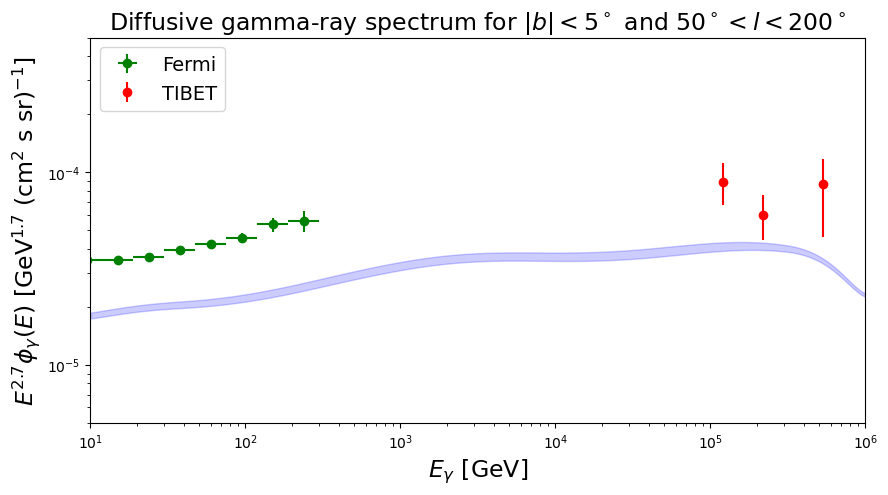

In [364]:
# Outer Galaxy plot
alpha = 2.7
plt.figure(figsize=(10, 5))
plt.fill_between(Energy_gamma, Igamma_Lipari_C_Pythia8_outerGalaxy * Energy_gamma**alpha, Igamma_Lipari_Fe_Pythia8_outerGalaxy * Energy_gamma**alpha, color='blue', alpha=0.2)
plt.errorbar(E_Fermi_outerGalaxy, phi_Fermi_outerGalaxy * E_Fermi_outerGalaxy**alpha, yerr=(phi_min_Fermi_outerGalaxy, phi_max_Fermi_outerGalaxy)*E_Fermi_outerGalaxy**alpha, xerr=(E_min_Fermi_outerGalaxy, E_max_Fermi_outerGalaxy), fmt='o', color='green', label='Fermi')
plt.errorbar(E_TIBET_outerGalaxy, phi_TIBET_outerGalaxy, yerr=(phi_min_TIBET_outerGalaxy, phi_max_TIBET_outerGalaxy), fmt='o', color='red', label='TIBET')
plt.loglog()
plt.ylim(5e-6, 5e-4)
plt.xlim(1e1, 1e6)
plt.xlabel(r'$E_\gamma$ [GeV]', fontsize=17)
plt.ylabel(r'$E^{2.7}\phi_\gamma(E)$ [GeV$^{1.7}$ (cm$^2$ s sr)$^{-1}$]', fontsize=17)
plt.legend(ncol=1, fontsize=14, loc='upper left')
plt.title('Diffusive gamma-ray spectrum for $|b|<5^\circ$ and $50^\circ < l < 200^\circ$', fontsize=17)
plt.savefig('Plots/gamma_outer_galaxy.png')